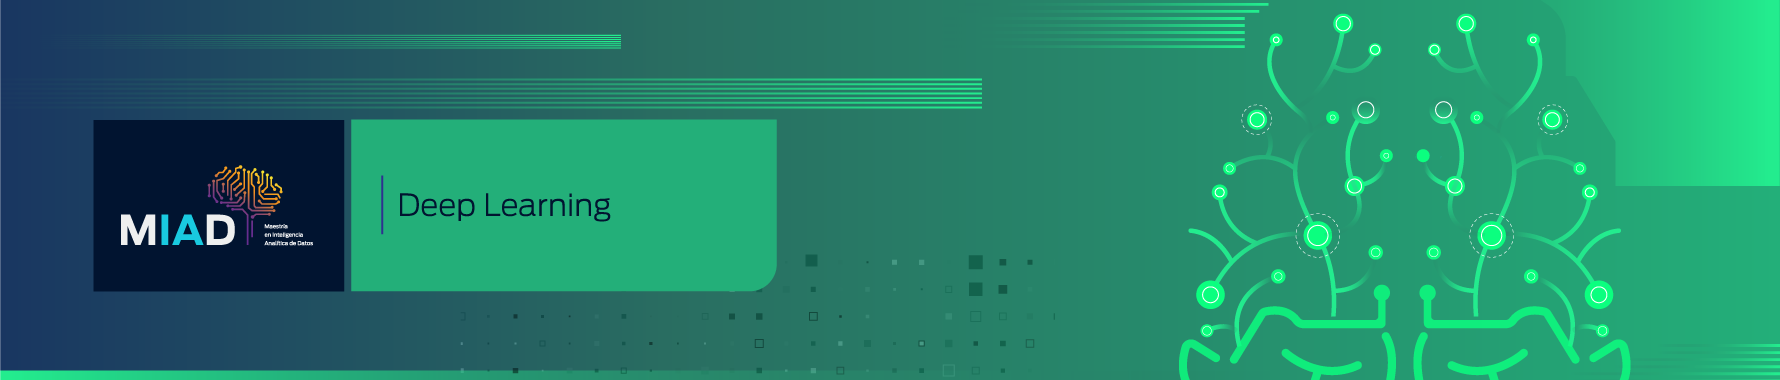

# Introducción a Redes Convolucionales

## Experimentando con Padding y Strides

### Propósito 

En redes neuronales convolucionales se requiere el uso de algunos filtros para facilitar la detección de bordes. Uno de estos métodos es el _padding,_ el cual se refiere a la inclusión de pixeles vacíos alrededor de los bordes de una imagen con el fin de conservar su tamaño original cuando se aplica un filtro convolucional. Por otra parte, los _strides_ hacen referencia al incremento del tamaño del paso en el cual permitimos deslizar un filtro en una imagen.

En este notebook revisaremos el funcionamiento de estos procesos en detalle y los implementaremos para procesar una imagen y evidenciar sus efectos.

### Instrucciones generales

1. Cuando se le solicite declarar una estructura de datos debe usar el nombre exigido.

2. Utilice estrictamente los tipos de datos y nombres de variable indicadas en los enunciados de los ejercicios.

3. Evite crear, eliminar o modificar celdas de este notebook (salvo lo que se le indique) pues puede afectar el proceso de calificación automático.

### Introducción

La operación de convolución presenta un fenómeno de reducción de dimensiones que puede llegar a ser problemático cuando se realizan varias operaciones consecutivas. Revisemos el siguiente ejemplo:

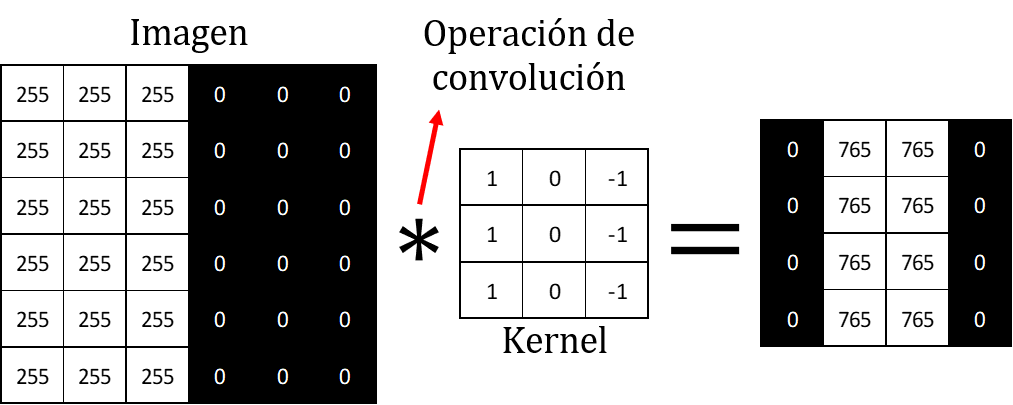

Nótese que solo hay 16 pasos posibles para que el filtro alcance el final de la imagen tanto de manera vertical como horizontal. Lo anterior lleva a que la imagen de salida sea de dimensiones $4\times 4$. La fórmula que utilizamos para calcular el "encogimiento" de la imagen de dimensión $(m\times m)$ teniendo un kernel de tamaño $(f\times f)$ corresponde a:
\begin{equation*} 
(m\times m) * (f\times f) = (m-f+1)*(m-f+1) \end{equation*}

Este fenómeno tiene la consecuencia de que si se ejecutan operaciones de convolución consecutivamente, la imagen final puede ser extremadamente pequeña. Este problema de pérdida de información se debe a que no se puede deslizar el filtro por los pixeles del borde y, por lo tanto, no se pueden hacer las convoluciones de forma completa. Es importante tener en cuenta que esta reducción de dimensiones se pronuncia cuando tenemos filtros de mayor dimensión.

### Padding

Una forma de solucionar el problema de encogimiento enunciado anteriormente consiste en rellenar nuestra imagen con pixeles vacíos (con valor 0) alrededor de los bordes. Esta técnica se conoce como _padding_.

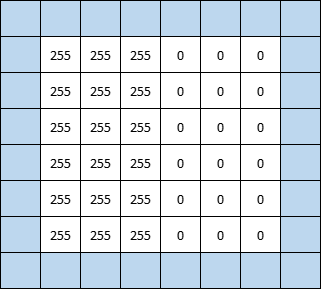

Si aplicamos la convolución con el mismo filtro, esta vez se lograrán hacer 32 pasos y se obtendrá una imagen $6\times 6$, del mismo tamaño de la imagen original.

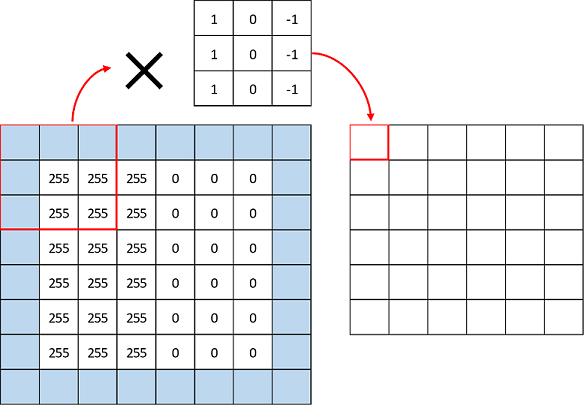

Para lograr aplicar el _padding_ apropiadamente, es necesario añadir suficientes pixeles en los bordes tal que la imagen resultante tenga las mismas dimensiones que la entrada de imagen en la operación de convolución. El número de píxeles a agregar en cada borde $p$ depende del tamaño del filtro $f$ y se puede calcular con la siguiente ecuación si la dimensión es impar:
\begin{equation} p = \frac{f-1}{2} \end{equation}

Dado que las dimensiones comunes de filtros son de $3\times 3$, $5\times 5$ y $7\times 7$, esta ecuación suele ser suficiente para aplicar la técnica satisfactoriamente.

### Strides

Este concepto se refiere al tamaño del paso que se da cuando se desliza el filtro convolucional a través de la imagen de entrada. Por defecto, el paso (_stride_) es de 1 pixel hacia la derecha o hacia abajo. Con un _stride_ de 2, delizaríamos el filtro dos pixeles en cada uno de los pasos. 

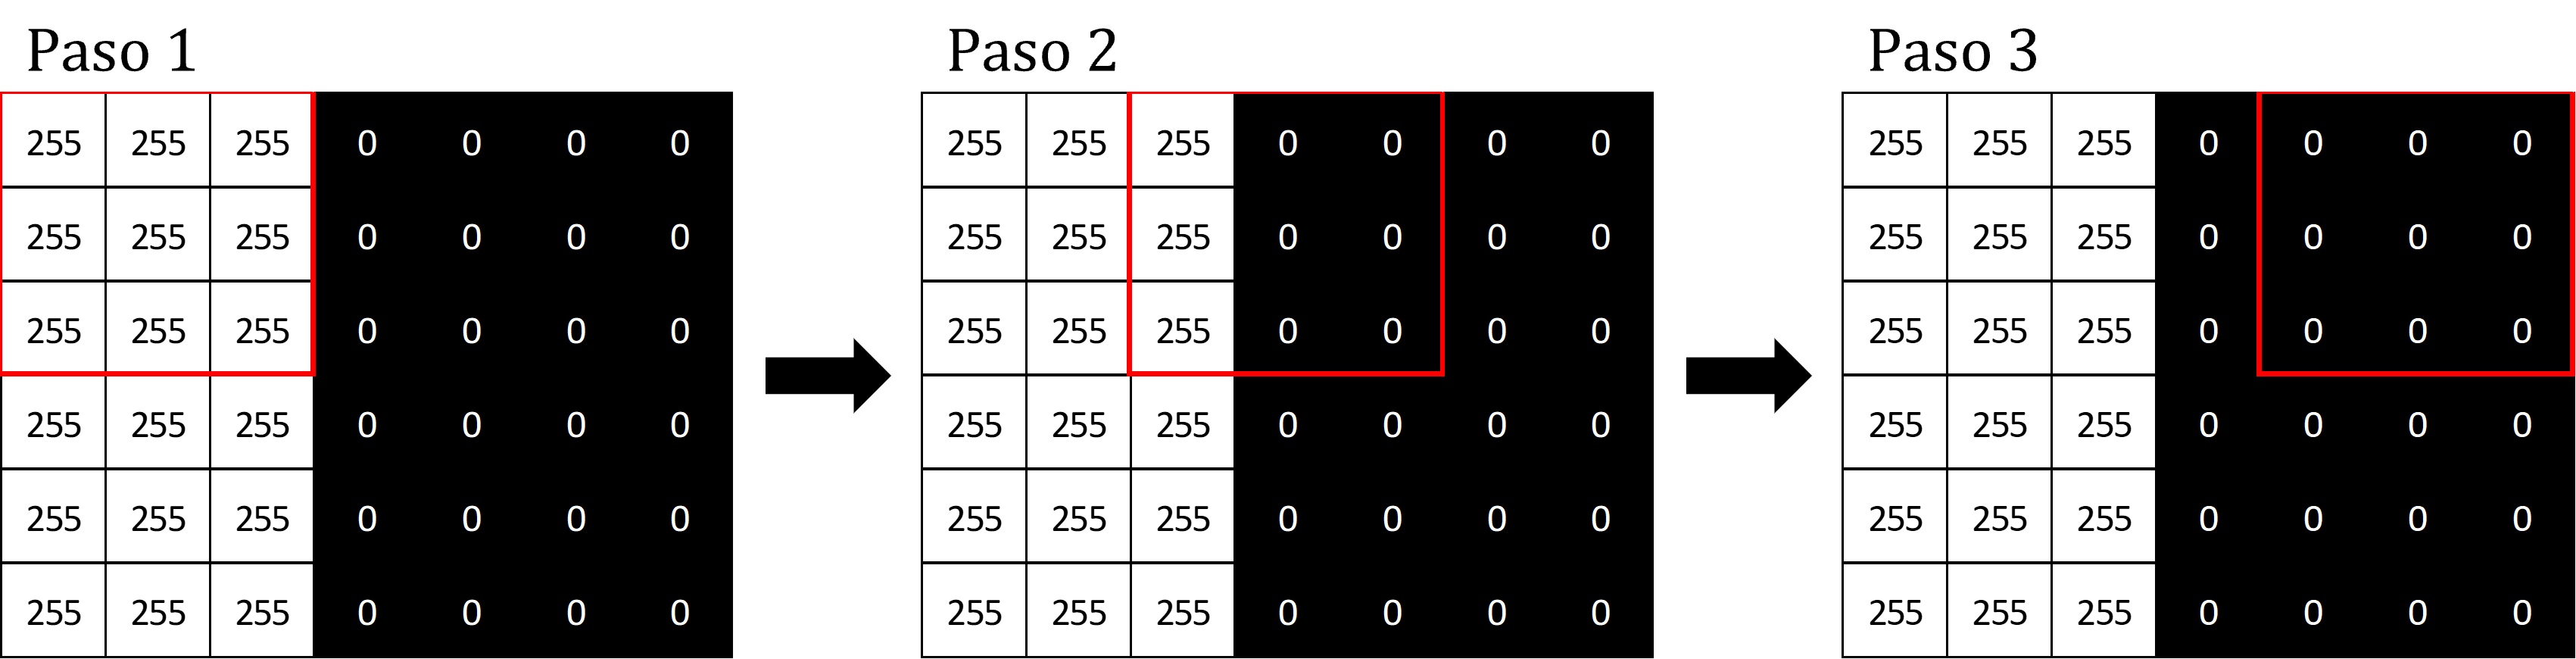

Al deslizar el filtro más rapido, el proceso se terminará más rápido y por tanto el tamaño de la salida será más pequeño teniendo en cuenta que este depende del número de pasos. Por ejemplo, si deslizamos un filtro de $3\times 3$ en una imagen de $7\times 7$, podemos solo dar dos pasos hasta que se alcance el final de la imagen asumiendo un stride de 2. Por lo anterior, en total hubo 3 pasos en el proceso y por tanto se tendría una salida de $3\times 3$. El resultado de esta convolución también nos permite detectar el borde pero en menos pasos gracias al stride aplicado:

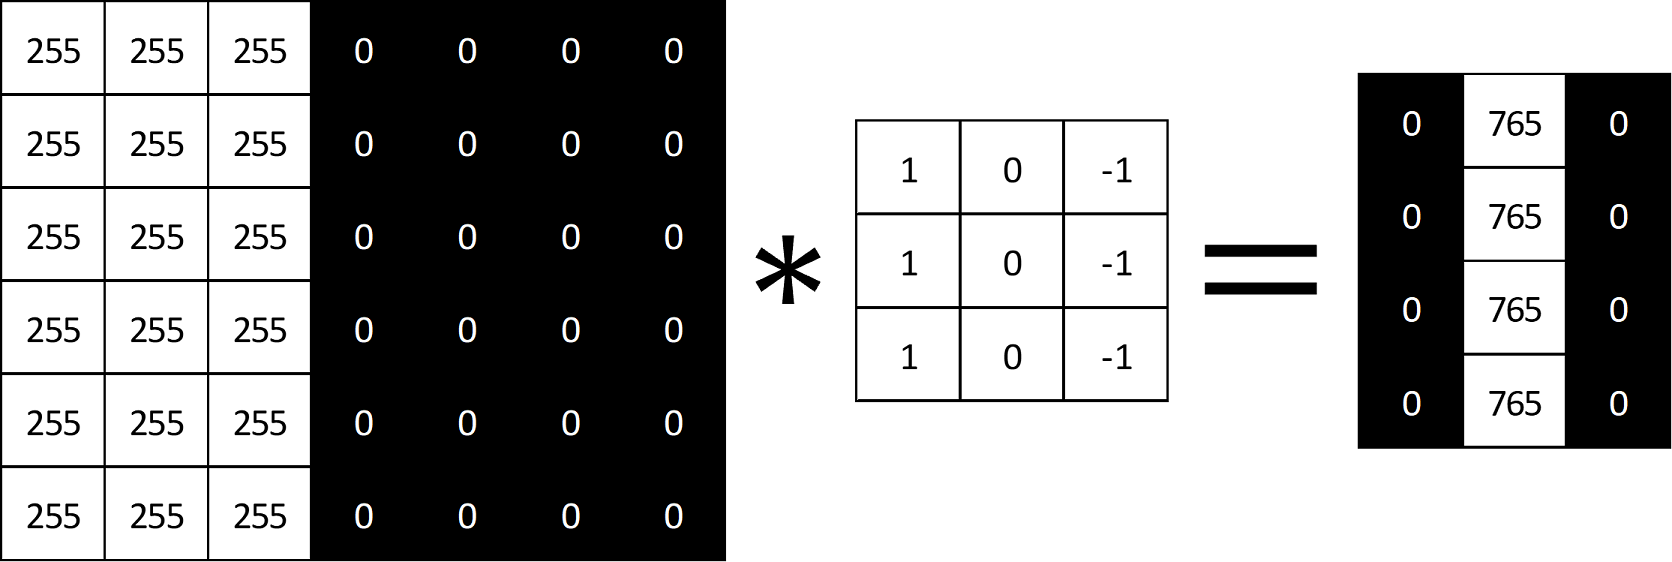

Podemos calcular el tamaño de la salida dependiento de la dimensión del kernel $f$, la dimensión original de la imagen $n$ y el stride $s$:
\begin{equation*} output= \frac{n-f}{s} + 1 \end{equation*}



La justificación del uso de los _strides_ es que, si bien a menor tamaño de paso, más información va a ser capturada en la salida, también se tendrá más información redundante dado que va a haber sobrelapamiento en los filtros aplicados a la imagen original. Por ejemplo, cuando aplicamos un filtro $3\times 3$ que se mueve con stride de 1, un kernel va a compartir 2/3 de sus pixeles de entrada con el kernel adyacente:

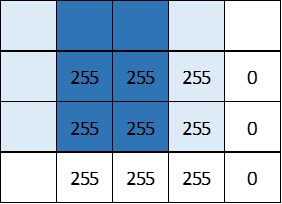

Por otro lado, si se incrementa el tamaño del paso, pocos parámetros se compartirían entre filtros y la salida será de menor dimensión, lo que lleva a tener en cuenta menor detalle. Adicionalmente, es importante considerar que entre más operaciones de filtrado se realicen, mayor poder computacional se necesita. Si nuestra red neuronal solo requiere entendimiento de mayor nivel, se puede utilizar un stride más grande.

## Implementación
### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:

In [10]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

### Carga de la imagen
Utilizamos la librería _cv2_ para cargar, visualizar y transformar una imagen a escala de grises.

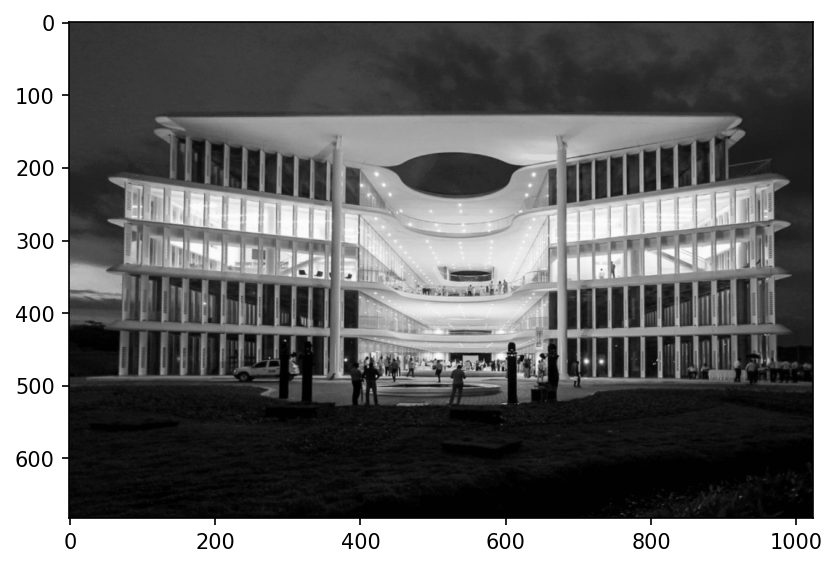

In [11]:
img=cv2.imread("sede-caribe-uniandes.png")
imgTest = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(dpi=150)
#Para mostrar la imagen correctamente utilizando matplotlib, se deben reorganizar los canales de OpenCV de BGR a RGB.
plt.imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
plt.show()

### Convolución usando padding

En primer lugar, se inicializarán los parámetros de entrada: la imagen a analizar, el kernel a aplicar y el nivel de padding deseado. Entonces, vamos a definir un kernel y un valor de padding $pd$:

In [12]:
image = imgTest
kernel = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
pd = 2

Ahora, necesitamos hacer el cómputo de las dimensiones de la matríz de la salida. Si consideramos padding, se sigue esta fórmula: 
$$n_{out}=n_{in}+2pd-k+1$$

Donde $n_{out}$ es la dimensión de salida, $n_{in}$ la de entrada, $p$ el nivel de padding y $k$ es la dimensión del kernel. Lo anterior debe ser implementado en cada dimensión con el objetivo de crear la matriz de salida con el resultado de la convolución:

In [13]:
KernelDim_x = kernel.shape[0]
KernelDim_y = kernel.shape[1]
ImgDim_x = image.shape[0]
ImgDim_y = image.shape[1]
Output_x = int(ImgDim_x + 2*pd - KernelDim_x + 1)
Output_y = int(ImgDim_y + 2*pd - KernelDim_y + 1)
output = np.zeros((Output_x, Output_y))

Ahora, vamos a implementar el padding sobre la imagen original. Para efectos de este laboratorio haremos un padding par, es decir, que se van a agregar el mismo número de filas a cada uno de los bordes. En este caso, es posible usar la función `Pad` de `NumPy` para crear los bordes de la matriz:

In [14]:
def padding(image, pd):
    padd=np.pad(image, pad_width=pd)
    return (padd)
imagePadded = padding(image,pd)

Ahora vamos a continuar con la convolución de la imagen. En primer lugar, vamos a iterar sobre los pixeles a nivel vertical con un criterio de parada que detenga el ciclo una vez el kernel alcance la parte inferior de la imagen. Luego, se tiene un ciclo que itera sobre cada elemento en x, por lo que aquí tambien vamos a incluir un criterio de parada para cuando estemos llegando al borde derecho de la imagen y se reinicie el proceso de convolución. 

Finalmente, vamos a incluir la operación de convolución que multiplica el filtro por los pixeles de la imagen en cada uno de los desplazamientos, hace la suma de estos productos y los guarda en la matriz de salida. 

In [15]:
#Se itera en cada pixel de la dirección "y"
for y in range(imagePadded.shape[1]):
    #Se revisa si el kernel aplicado sobre a fila "y" no está por fuera de la imagen. 
    #Si lo está, termina el ciclo para "y".
    if y > imagePadded.shape[1] - KernelDim_y:
        break
    #Se itera en cada pixel de la dirección "x"
    for x in range(imagePadded.shape[0]):
        #Se revisa si el kernel aplicado sobre la columna "x" no está por fuera de la imagen.
        #Si lo está, termina el ciclo.
        if x > imagePadded.shape[0] - KernelDim_x:
            break
        #Se aplica el producto de Hadamard y se suman los elementos de la matriz resultante.
        try:
            output[x, y] = (kernel * imagePadded[x: x + KernelDim_x, y: y + KernelDim_y]).sum()
        except:
            break

Podemos entonces ver la imagen de salida, así:


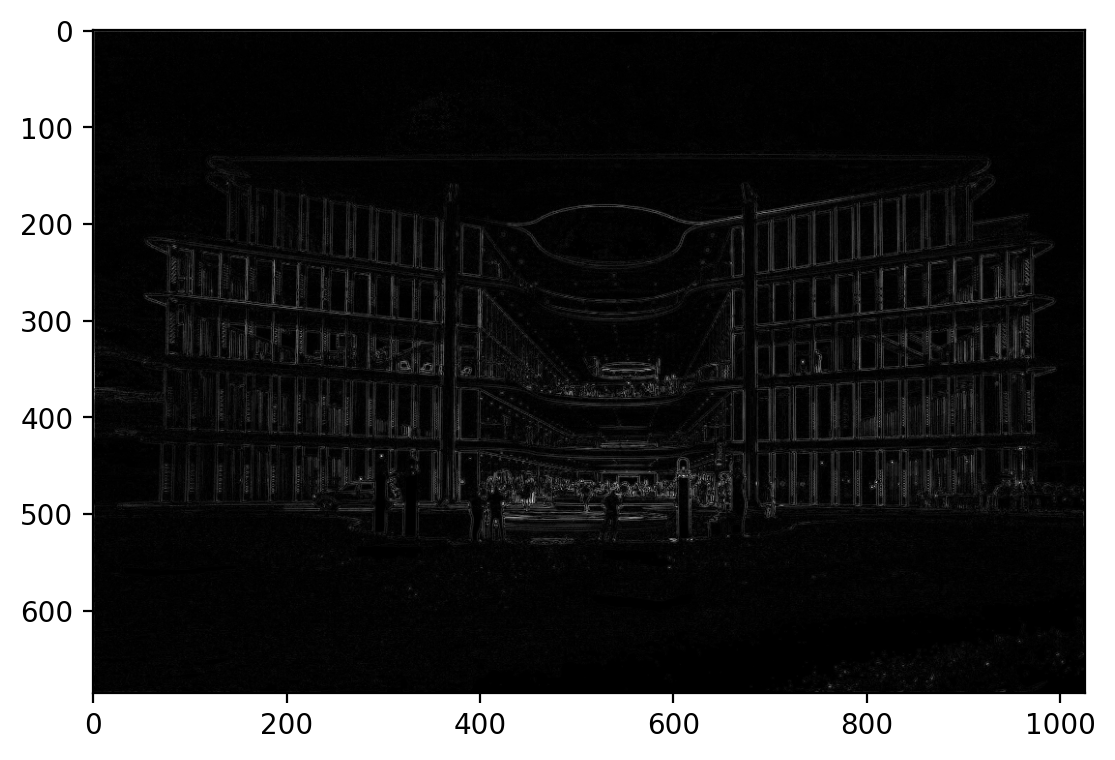

In [16]:
plt.figure(dpi=200)
#Se debe reescalar el resultado de Sobel a una imagen en entero que varía de 0 a 255.
convert_back = cv2.convertScaleAbs(output, alpha=255/output.max())
#Para mostrar la imagen correctamente utilizando matplotlib, se deben reorganizar los canales de OpenCV de BGR a RGB.
plt.imshow(cv2.cvtColor(convert_back, cv2.COLOR_BGR2RGB))
plt.show()

### Actividad individual: Convolución incluyendo padding y strides.

Ahora, desarrolle una función que reciba la imagen, el kernel, el nivel de padding y, además, el nivel de stride. Para incluir los strides hay que tener en cuenta varios aspectos:
*   Las dimensiones de la imagen de salida `output` dependen del nivel de strides $s$ como indica la siguiente fórmula:
$$n_{out}=\Biggl[\frac{n_{in}+2p-k}{s}\Biggr]+1$$
*   Debe agregar un condicional para cada dirección donde se garantice que la convolución se realiza según el tamaño de paso indicado por los strides. _Pista:_ Aproveche la operación módulo `a%b`, el cual le retorna el residuo de la división de a entre b (devuelve 0 cuando a es múltiplo de b, de lo contrario da un entero). 
*   Debido al funcionamiento de la técnica _stride_, no se realiza convolución por cada pixel y la dimensión de la imagen de salida se reduce, por lo que debe garantizar que las operaciones se realizan según el tamaño de paso. _Pista:_ Puede utilizar un contador para cada dirección que se vaya actualizando cada vez que se valide la condición del inciso anterior. El valor de este contador sería el índice del pixel de la imagen de salida `output`. Tenga en cuenta que, si aplica un nivel de stride de 2, la imagen de salida se encoge a la misma razón para ambas direcciones.

In [ ]:
def convolve2D(image, kernel, pd=0, strides=1):
    KernelDim_x = kernel.shape[0]
    KernelDim_y = kernel.shape[1]
    ImgDim_x = image.shape[0]
    ImgDim_y = image.shape[1]

    imagePadded = padding(image,pd)

    Output_x = ((ImgDim_x + 2*pd - KernelDim_x) // strides )+ 1
    Output_y = ((ImgDim_y + 2*pd - KernelDim_y) // strides)+ 1

    output = np.zeros((Output_x, Output_y))

    for j in range(Output_y):
        for i in range(Output_x):
            x=i*strides
            y=j*strides
            output[i, j] = (kernel * imagePadded[x: x + KernelDim_x, y: y + KernelDim_y]).sum()          
    return output


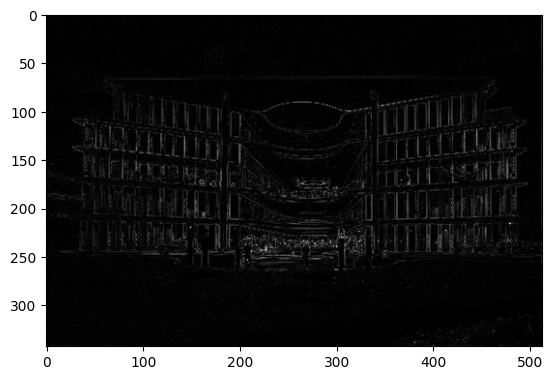

In [22]:
# Tests
kernel = np.array([[-1, -1, -1], 
                   [-1, 8, -1], 
                   [-1, -1, -1]])
image = imgTest
pd=2
strides=2
convol = convolve2D(image,kernel,pd,strides)

plt.figure(dpi=100)
#Se debe reescalar el resultado de Sobel a una imagen en entero que varía de 0 a 255.
convert_back = cv2.convertScaleAbs(convol, alpha=255/convol.max())
#Para mostrar la imagen correctamente utilizando matplotlib, se deben reorganizar los canales de OpenCV de BGR a RGB.
plt.imshow(cv2.cvtColor(convert_back, cv2.COLOR_BGR2RGB))
plt.show()

assert round(np.linalg.norm(convol),1) == round(21426.07500220234,1)

In [ ]:
#Pruebas ocultas para uso del equipo docente